# Part 1: Parameter estimation in a state-space model

In [1]:
import pandas as pd

df = pd.read_csv("transformer_data.csv")

### 1.1

What about sigma2? Without I cannot simulate the observation equation?

=> Assumed as sigma2 = np.random

In [10]:
import numpy as np
np.random.seed(42)

a, b, sigma1, x0, n = 0.9, 1, 1, 5, 100
params = (a, b, sigma1)

def simulate_from_model_1d(par, n:int=100, x0:float=5.0):
    a, b = par[0], par[1]
    sigma1 = par[2]
    sigma2 = np.random.rand()

    X = np.zeros(n+1)
    Y = np.zeros(n)
    X[0] = x0  # initial condition

    for t in range(n):
        X[t] = a * X[t-1] + b + np.random.normal(0, sigma1)
        Y[t] = X[t] + np.random.normal(0, sigma2)

    return Y, X[1:]


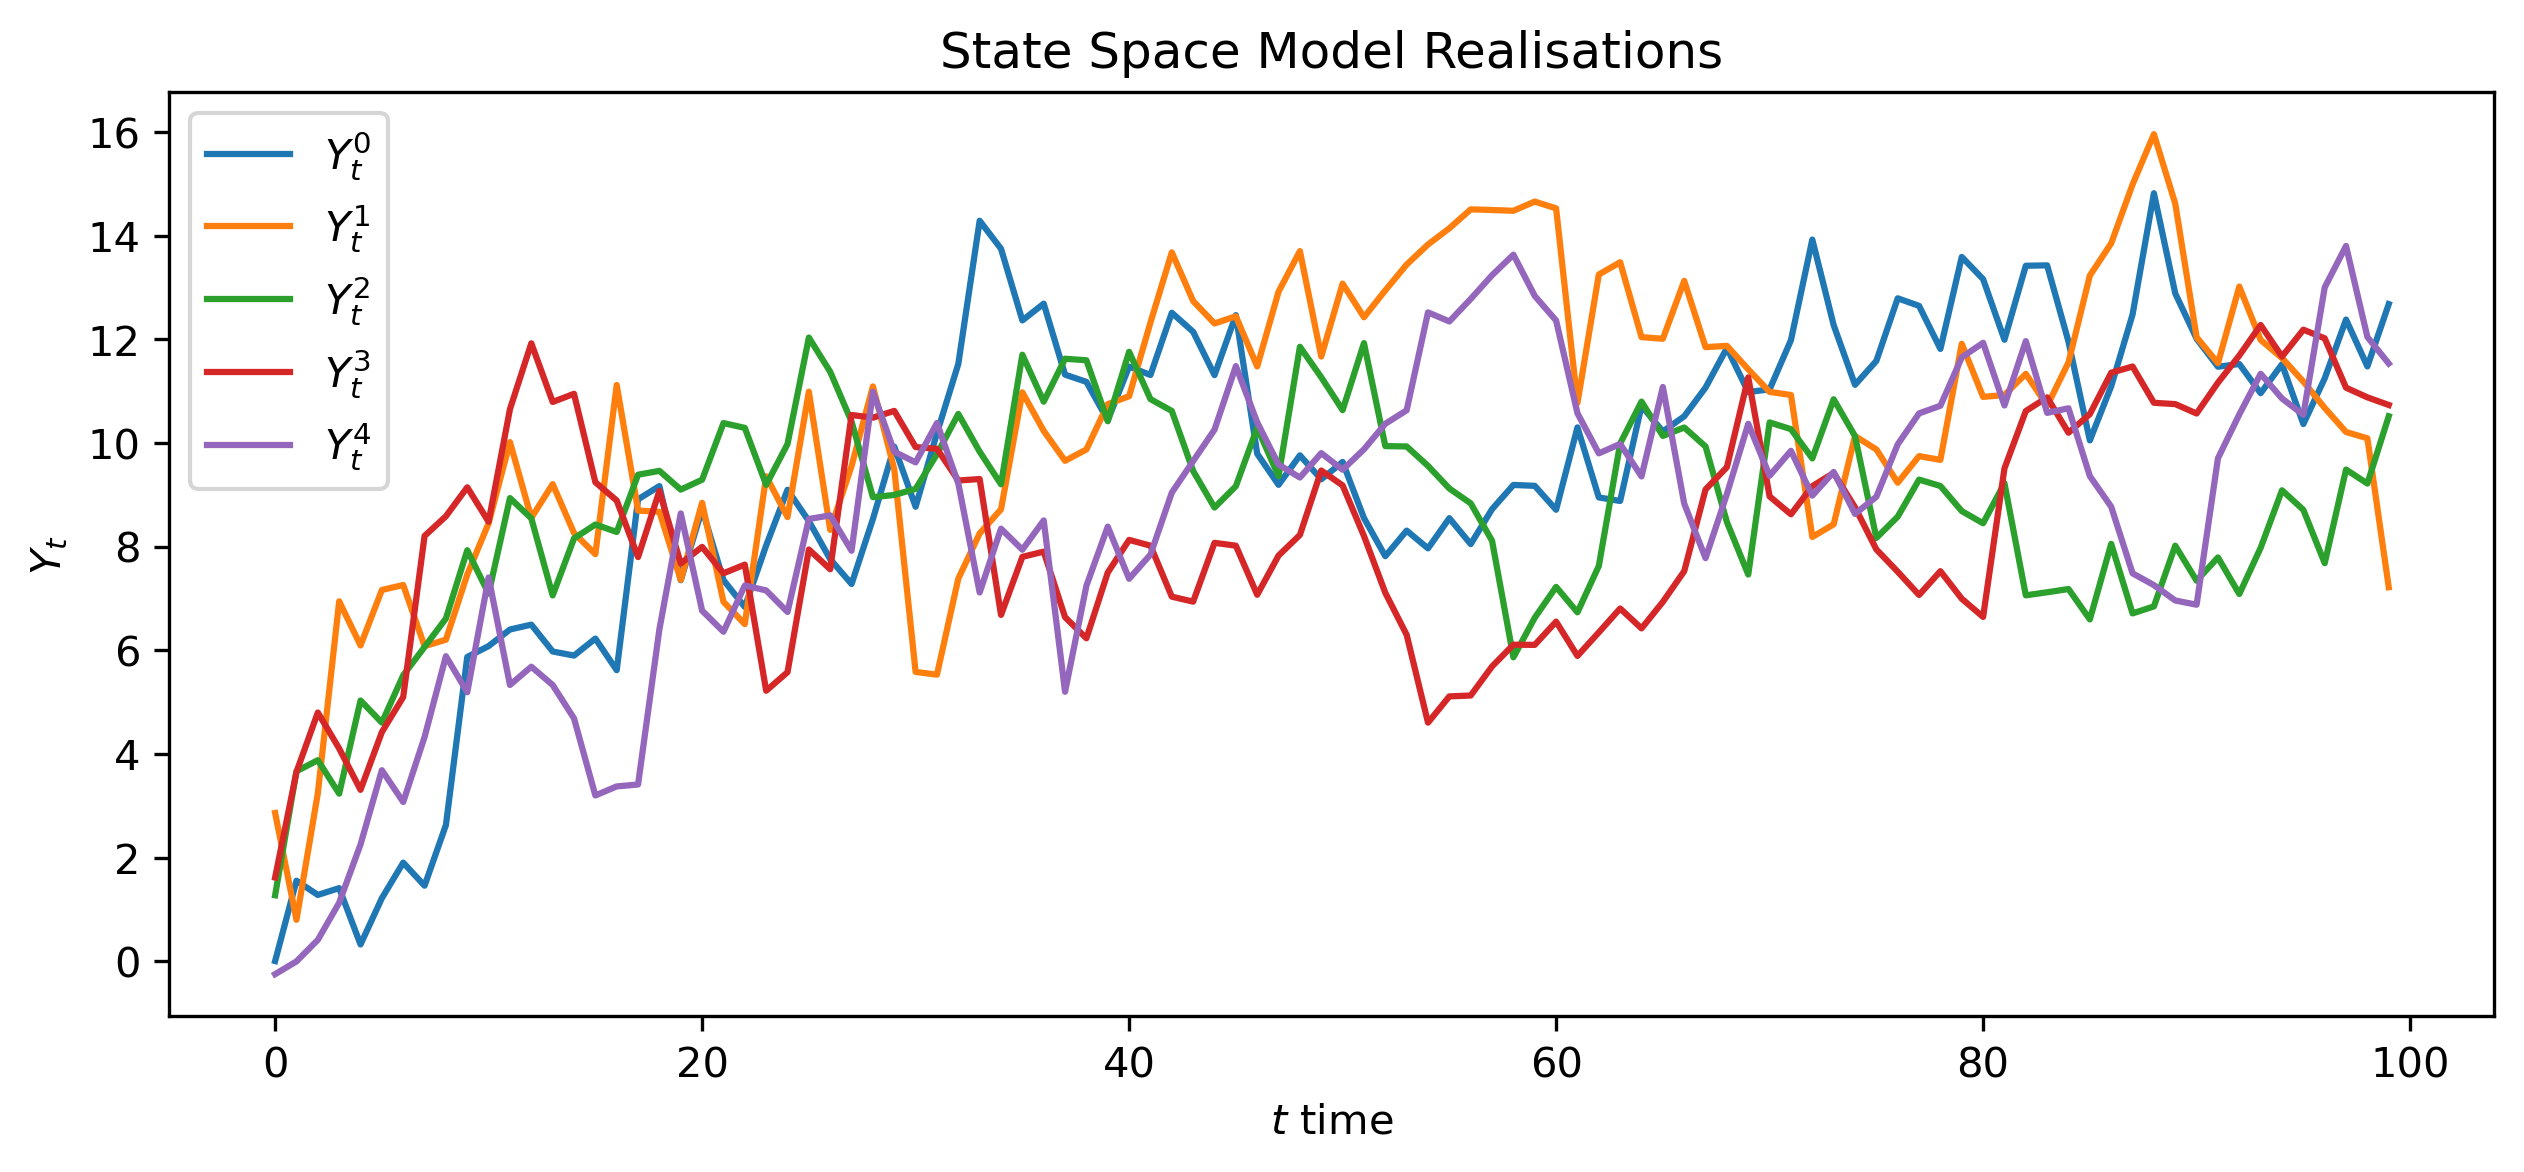

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4), dpi=300)
plt.title("State Space Model Realisations")
for i in range(5):
    y, x = simulate_from_model_1d(params)
    plt.plot(y, label=f"$Y_t^{i}$")
plt.xlabel("$t$ time")
plt.ylabel("$Y_t$")
plt.legend()

### 1.2

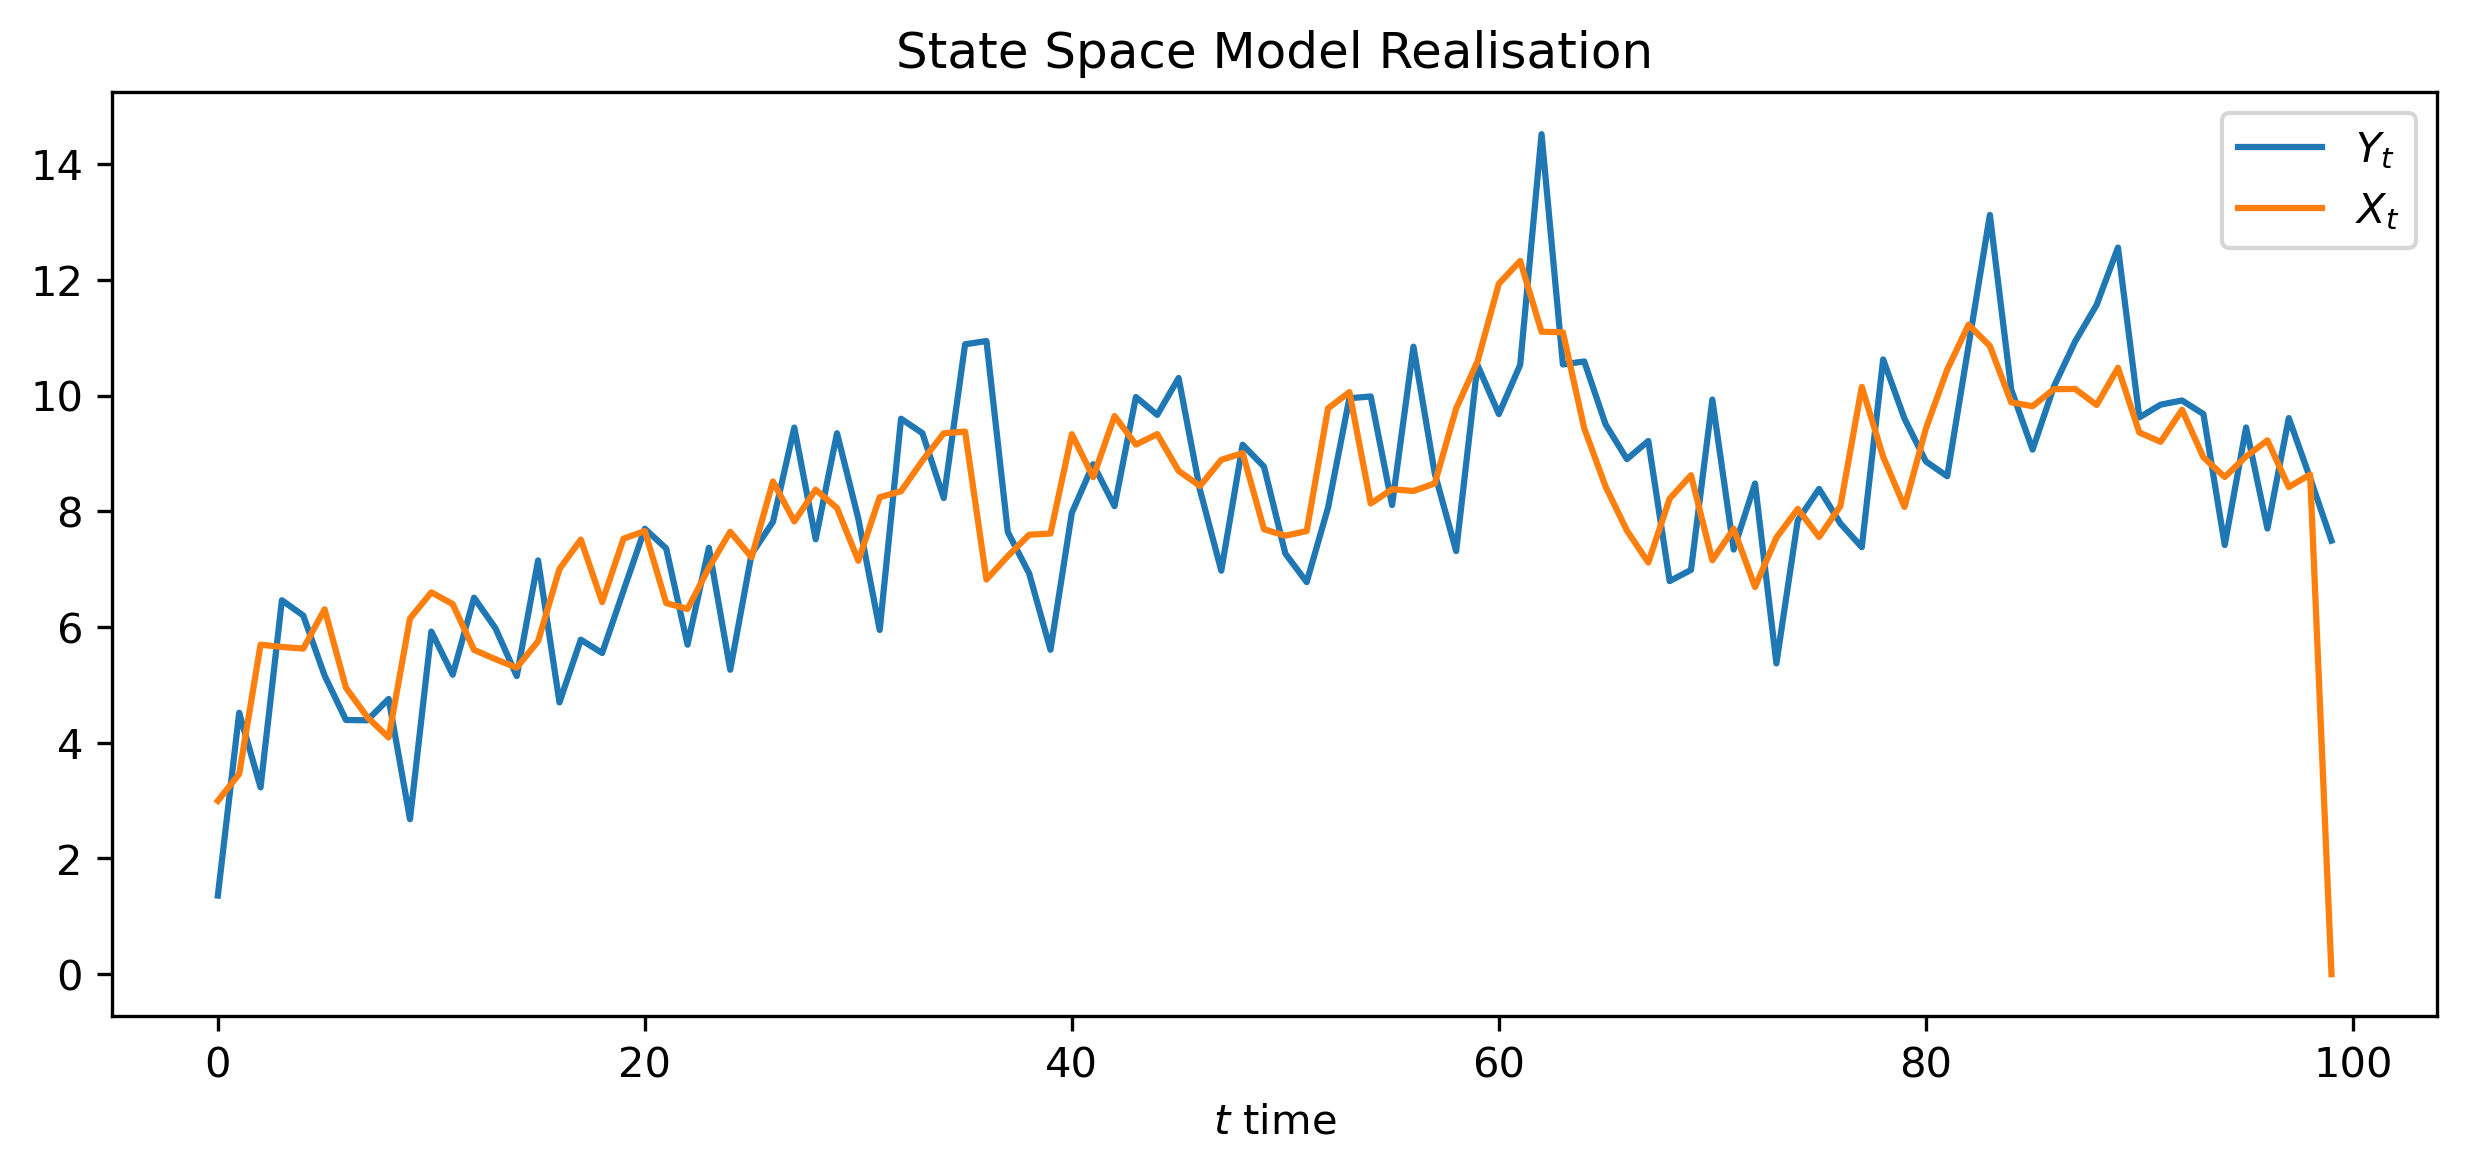

In [14]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

a, b, sigma1, sigma2, x0, n = 0.9, 1, 1, 1, 5, 100
params = (a, b, sigma1, sigma2)

def simulate_from_model_1d(par, n:int=100, x0:float=5.0):
    a, b = par[0], par[1]
    sigma1, sigma2 = par[2], par[3]

    X = np.zeros(n+1)
    Y = np.zeros(n)
    X[0] = x0  # initial condition

    for t in range(n):
        X[t] = a * X[t-1] + b + np.random.normal(0, sigma1)
        Y[t] = X[t] + np.random.normal(0, sigma2)

    return Y, X[1:]

plt.figure(figsize=(10,4), dpi=300)
plt.title("State Space Model Realisation")
y, x = simulate_from_model_1d(params)
plt.plot(y, label=f"$Y_t$")
plt.plot(x, label=f"$X_t$")
plt.xlabel("$t$ time")
plt.legend()

### 1.3

In [18]:
def my_kalman_filter(y, theta, R:float=1.0, x0:float=5.0, p0:float=1):
    a, b, sigma1 = theta
    sigma2 = R

    x_pred, P_pred, c = x0, p0, 1
    T = len(y)

    loglik = 0.0
    x_preds, x_filts, innos, Sigma_xxs, Sigma_yys, Sigma_xx1s = [x_pred], [], [], [], [], [P_pred]
    for t in range(T):
        # Prediction step
        x_pred = a * x_pred + b
        P_pred = a**2 * P_pred + sigma1**2
        x_preds.append(x_pred)
        Sigma_xx1s.append(P_pred)

        # Observation prediction
        y_pred = c * x_pred
        S = c**2 * P_pred + sigma2**2
        innov = y[t] - y_pred
        Sigma_yys.append(S)
        innos.append(innov)

        # Log-likelihood
        loglik += -0.5 * (np.log(2 * np.pi * S) + (innov**2) / S)

        # Kalman gain / filter
        K = P_pred * c / S
        x_pred = x_pred + K * innov
        P_pred = (1 - K * c) * P_pred
        x_filts.append(x_pred)
        Sigma_xxs.append(P_pred)
    
    return x_preds, x_filts, innos, Sigma_xxs, Sigma_yys, Sigma_xx1s

In [32]:
a, b, sigma1 = 0.9, 1, 1
theta = (a, b, sigma1)
R = 1 #np.random.rand() # sigma2
params = (a, b, sigma1, 1)

y, x = simulate_from_model_1d(params)

x_preds, x_filts, innos, Sigma_xxs, Sigma_yys, Sigma_xx1s = my_kalman_filter(y, theta, R)

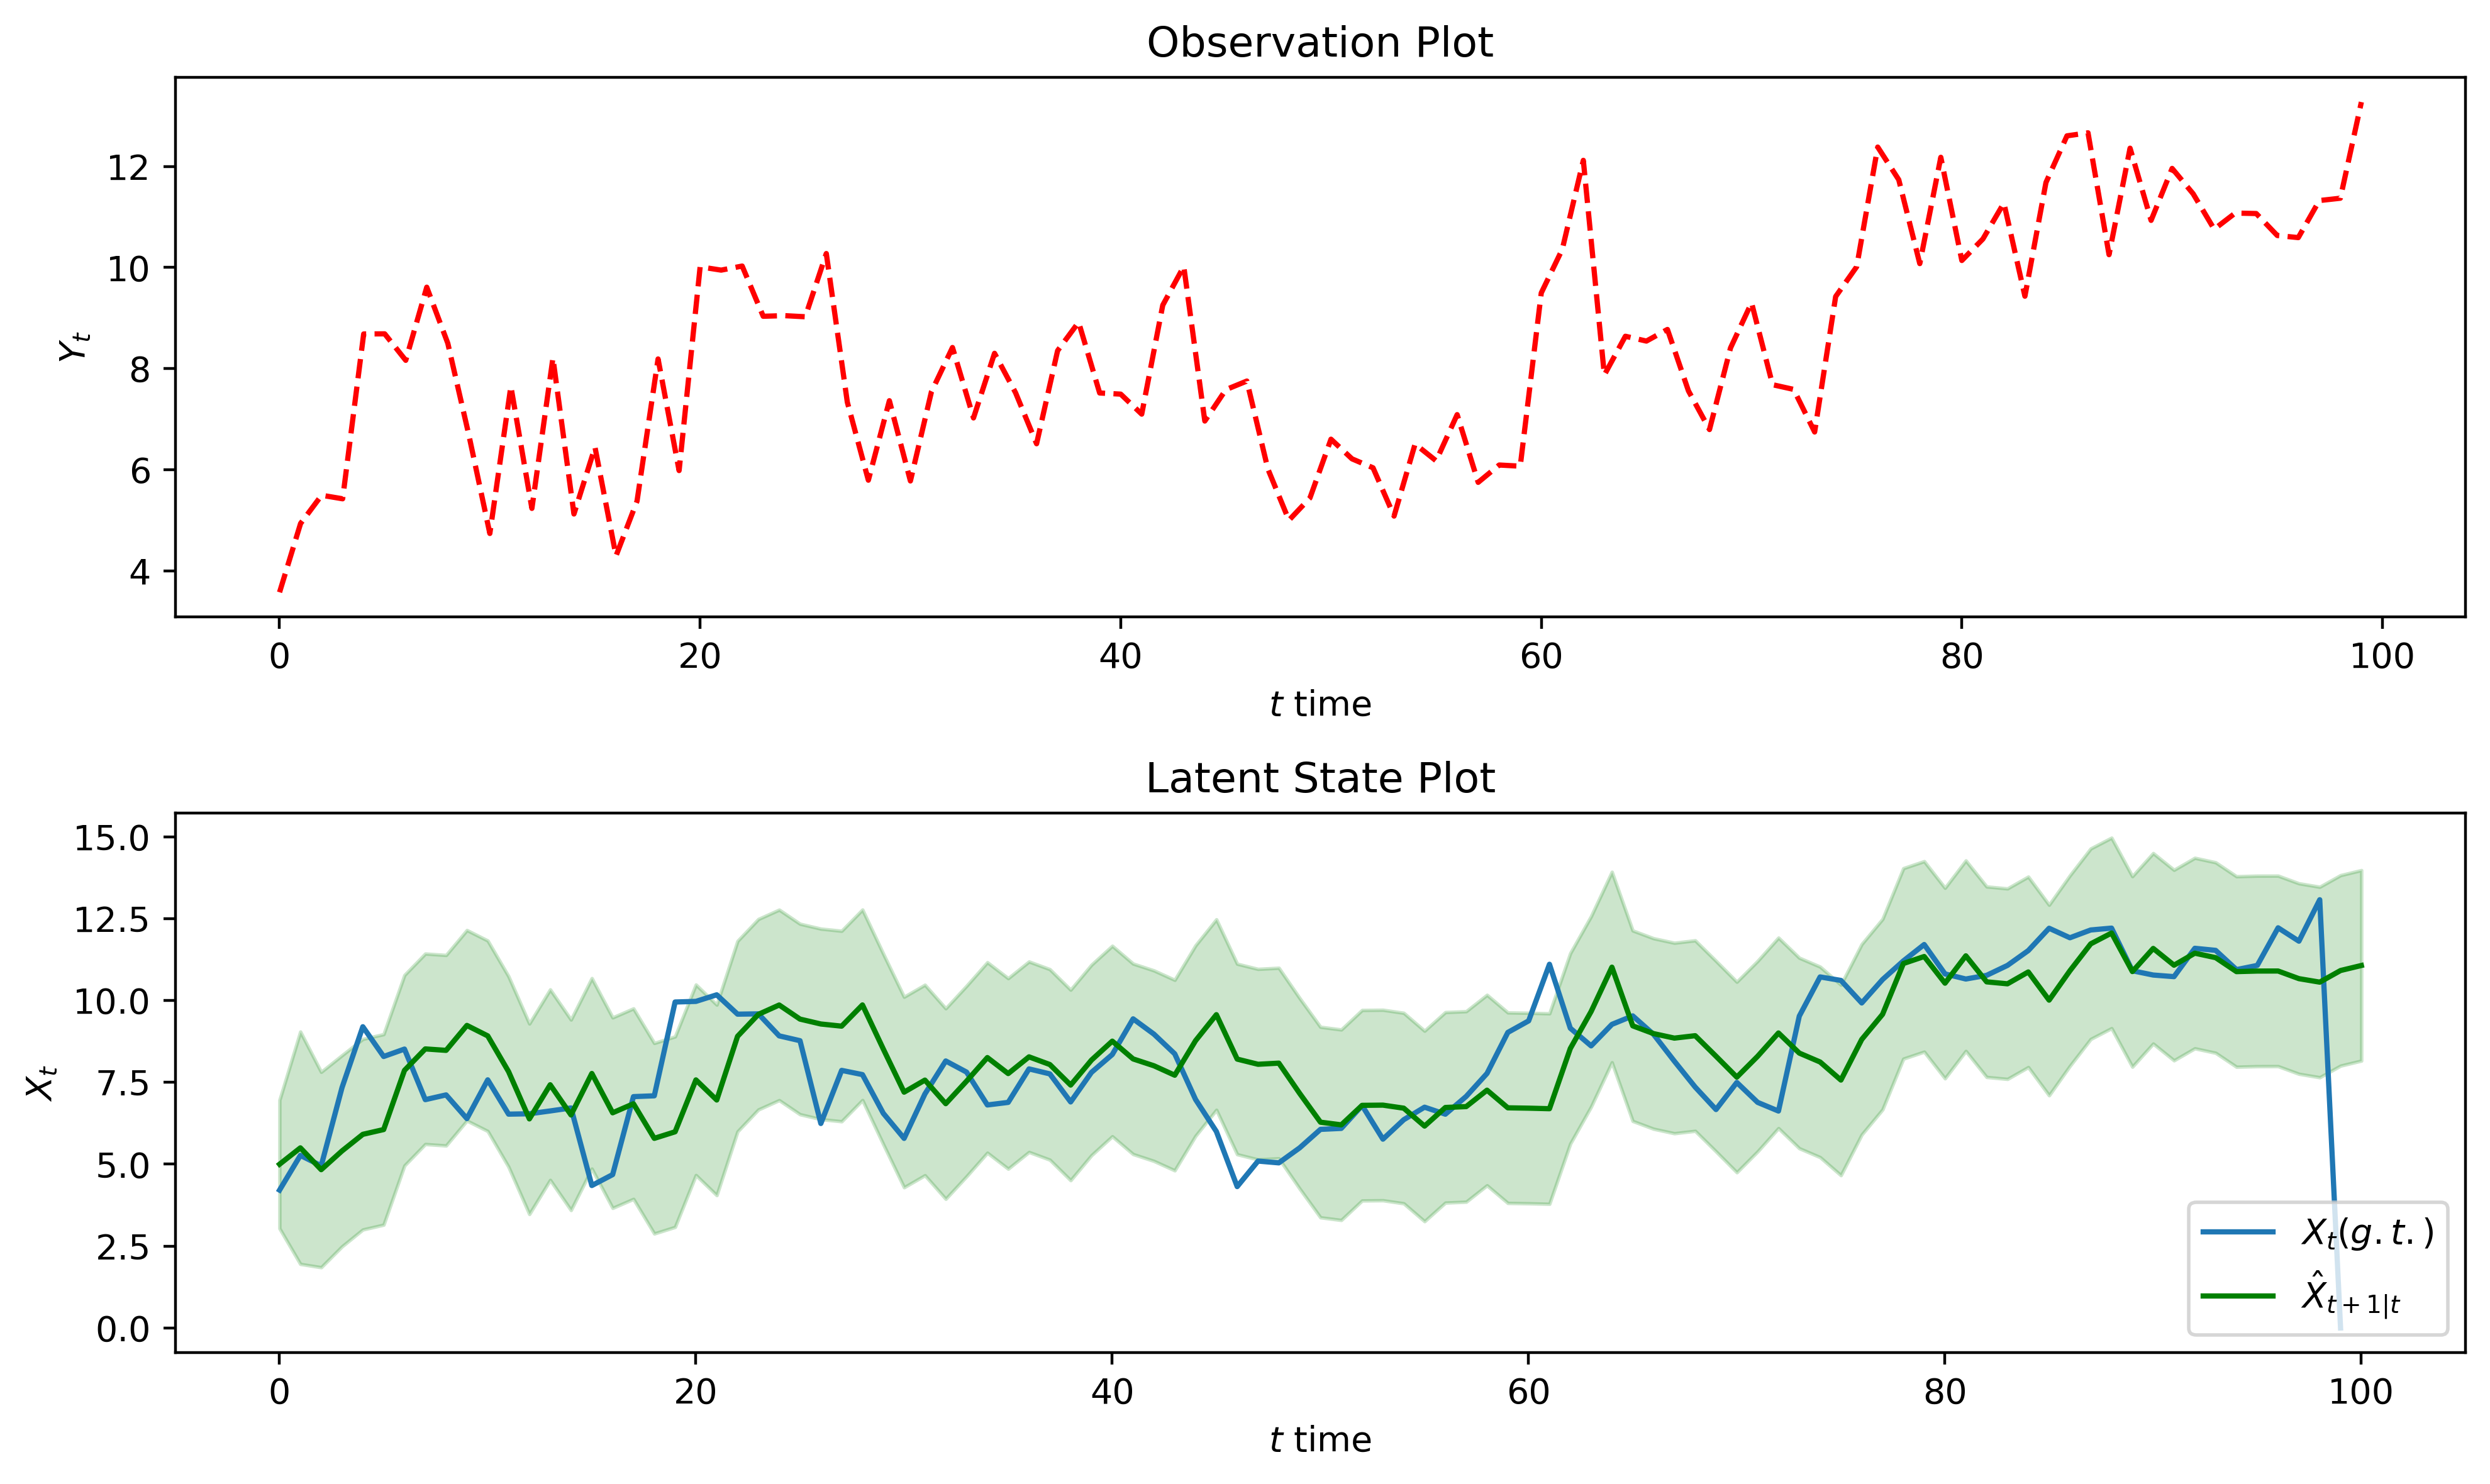

In [36]:
plt.figure(figsize=(10,6), dpi=400)
plt.subplot(2,1,1)
plt.title("Observation Plot")
plt.plot(y, label="$Y_t$", ls="--", color="r")
plt.xlabel("$t$ time")
plt.ylabel("$Y_t$")

plt.subplot(2,1,2)
plt.title("Latent State Plot")
plt.plot(x, label="$X_t (g.t.)$")
plt.plot(x_preds, label="$\hat{X}_{t+1|t}$", color='green')
plt.fill_between(np.arange(len(x_preds)), x_preds-np.array(Sigma_xx1s)*1.96, x_preds+np.array(Sigma_xx1s)*1.96, color='green', alpha=0.2)
plt.xlabel("$t$ time")
plt.ylabel("$X_t$")
plt.legend()

plt.tight_layout()